# Primera prueba con NBEATs

Vamos a Jugar con N BEATS y un cluster
Vamos a ver que pasa para Octubre y luego vemos.


Voy a ver de agrupar productos


*  En función de DTW voy a tener 3 clusters
*  En función de largos menores a 6 meses o poca incidencia en ventas, voy a ver la distribución en tiempo y voy a ajustar en función de eso.

en este primer caso voy a filtrar solamente un cluster, voy a tomar hasta 34 y calcular 36 y ver que da




## Preparo todo

In [2]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [3]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend



#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [4]:
!pip install pytorch_forecasting pytorch-lightning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import torch
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, TemporalFusionTransformer, metrics
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
import os


In [6]:
# Para reproducibilidad:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


## Levanto el dataset
En esta prueba voy a usar hasta 34 y predecir 36

In [7]:
# me traigo el archivo ya procesado con la duración completa
# prod cust completo, habrá que procesar
full_prod_cust = pd.read_csv(DATOS_DIR +'full_prod_ust.csv')
# productos a validar Son los que se van a estar vivos
productos_validar = pd.read_csv(DATOS_DIR +'product_id_apredecir201912.txt', sep='\t')
# me traigo el clasificador de clusters
df_llave= pd.read_csv(DATOS_DIR +'df_llave_cluster_93.csv')
#resumen_xy.head()

In [11]:
full_prod_cust.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id,duracion
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,20524_10234,34
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,20524_10032,35
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,20524_10217,34
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,20524_10125,34
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,20524_10012,36


In [9]:
df_llave.head()

,cluster_id,product_cust_id,std_ventas
0,1,20002_10001,110.699
1,2,20001_10001,106.033
2,2,20001_10004,114.273
3,3,20001_10007,51.573
4,1,20002_10007,54.293


In [10]:
## solamente como ejemplo, veo lo que espera NBeats para entender como componer
num_ids = 5
max_periodo = 38

rows = []
for pid in range(1, num_ids + 1):
    primer_periodo = np.random.randint(0, 5)  # Algunos arrancan después
    for t in range(primer_periodo, max_periodo + 1):
        rows.append({
            'product_client_id': f"P{pid}",
            'periodo': t,
            'ventas': int(abs(50 + 7*pid + 3.2*t + np.random.normal(0,8))),
            'tipo_cambio': 990 + t,
            'inflacion_prev': 0.01 + 0.01*np.sin(t/6.0),
        })
df = pd.DataFrame(rows)
df.head()

,product_client_id,periodo,ventas,tipo_cambio,inflacion_prev
0,P1,3,57,993,0.015
1,P1,4,72,994,0.016
2,P1,5,75,995,0.017
3,P1,6,84,996,0.018
4,P1,7,74,997,0.019


#### el dataset está armado como para el ejemplo

## Voy a separar los datos del cluster elegido, y voy a dejar aparte el dataset de entrenaminto y el de resultado

In [12]:
# me quedo solamente con los product_id que me interesan en este caso
df_cluster3 = df_llave[df_llave['cluster_id'] == 3][['product_cust_id']]
df_cluster3.head()

,product_cust_id
3,20001_10007
5,20001_10003
6,20001_10013
7,20002_10004
8,20003_10001


In [13]:
# ahora genero df_3 que contiene solamente las líneas de full_prod_cust concust_prod_id igual al product_cust_id de df_cluster3.
df_3 = full_prod_cust[full_prod_cust['cust_prod_id'].isin(df_cluster3['product_cust_id'])]
df_3.head()


,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id,duracion
70,201701,10007,20311,False,0.274,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_1000.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,19.276,34057.318,39613,0.057,900.327,5372,2.644,20311_10007,36
83,201701,10015,20311,False,0.127,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_1000.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,19.276,34057.318,39626,0.057,435.402,8275,1.278,20311_10015,36
98,201701,10028,20311,False,0.134,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_1000.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,19.276,34057.318,39641,0.057,92.708,22183,0.272,20311_10028,36
127,201701,10004,20311,False,0.650,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_1000.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,19.276,34057.318,39670,0.057,1738.918,1979,5.106,20311_10004,36
149,201701,10005,20311,False,0.115,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_1000.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,19.276,34057.318,39692,0.057,1058.825,3394,3.109,20311_10005,36


## Preparación general de los datos
Acá voy a procesar todos los datos. En esta primera prueba


*   Voy a dejar solamente columnas numéricas
*   Voy a guardar el df de interés hasta 34 y dejar el de 36 para chequear luego

OJO acá es donde debiera agregar más features luego





### Además renombro lo que tenía como secuencia como período para que me resulte más fácil luego

In [14]:
# voy a generar df_3_clean a partir de dropear una lista de columnas de df_3
columnas_eliminar=['product_id', 'customer_id', 'periodo','plan_precios_cuidados','date','date_mes','cat1','cat1_cat2','cat1_cat2_cat3','cat1_cat2_cat3_brand','cat1_cat2_cat3_brand_size','primera_venta', 'ultima_venta','alta_cliente','ultima_compra','vive','duracion']
df_3_clean = df_3.drop(columns= columnas_eliminar)
df_3_clean.head()

,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,stock_final,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id
70,0.274,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39613,0.057,900.327,5372,2.644,20311_10007
83,0.127,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39626,0.057,435.402,8275,1.278,20311_10015
98,0.134,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39641,0.057,92.708,22183,0.272,20311_10028
127,0.650,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39670,0.057,1738.918,1979,5.106,20311_10004
149,0.115,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39692,0.057,1058.825,3394,3.109,20311_10005


In [15]:
df_3_clean.head()

,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,stock_final,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id
70,0.274,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39613,0.057,900.327,5372,2.644,20311_10007
83,0.127,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39626,0.057,435.402,8275,1.278,20311_10015
98,0.134,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39641,0.057,92.708,22183,0.272,20311_10028
127,0.650,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39670,0.057,1738.918,1979,5.106,20311_10004
149,0.115,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39692,0.057,1058.825,3394,3.109,20311_10005


In [16]:
df_3_clean.rename(columns={'secuencia': 'periodo'}, inplace=True)
df_3_clean.head()

,tn,dif_tn,dif_por,anio,mes,periodo,trimestre,stock_final,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id
70,0.274,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39613,0.057,900.327,5372,2.644,20311_10007
83,0.127,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39626,0.057,435.402,8275,1.278,20311_10015
98,0.134,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39641,0.057,92.708,22183,0.272,20311_10028
127,0.650,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39670,0.057,1738.918,1979,5.106,20311_10004
149,0.115,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39692,0.057,1058.825,3394,3.109,20311_10005


In [17]:
# me guardo df_target como las filas de df_3_clean con periodo = 36
df_target = df_3_clean[df_3_clean['periodo'] == 36]
df_target.head()


,tn,dif_tn,dif_por,anio,mes,periodo,trimestre,stock_final,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id
2887920,0.023,0.0,0.0,2019,12,36,4,19.761,39,39,NaN,3.377,26217.067,43894,0.013,390.610,7955,1.490,20524_10009
2887941,0.847,0.0,0.0,2019,12,36,4,34.379,39,39,NaN,18.167,26217.067,22618,0.069,948.451,1925,3.618,20311_10007
2887945,0.306,0.0,0.0,2019,12,36,4,34.379,39,39,NaN,18.167,26217.067,22622,0.069,672.884,4910,2.567,20311_10004
2887961,0.255,0.0,0.0,2019,12,36,4,34.379,39,39,NaN,18.167,26217.067,22638,0.069,180.303,12586,0.688,20311_10028
2887970,0.147,0.0,0.0,2019,12,36,4,34.379,39,39,NaN,18.167,26217.067,22647,0.069,724.890,3497,2.765,20311_10005


In [18]:
# me guardo df_base como las filas de df_3_clean con periodo menor a 35
df_base = df_3_clean[df_3_clean['periodo'] < 35]
df_base.tail()

,tn,dif_tn,dif_por,anio,mes,periodo,trimestre,stock_final,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id
2814389,0.167,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57401,0.012,2325.243,2072,6.281,20853_10004
2814390,0.129,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57402,0.012,860.987,6487,2.326,20853_10012
2814395,0.067,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57407,0.012,1406.189,4164,3.798,20853_10006
2814419,0.881,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57431,0.012,348.734,10874,0.942,20853_10029
2814436,0.227,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57448,0.012,1457.230,3679,3.936,20853_10007


### ahora tengo que normalizar, me importa el 0 voy a dividir por la desvio/media y voy a guardar los resultados

In [19]:
# Supongamos que tus columnas a normalizar son
columnas_a_normalizar = ['tn', 'dif_tn','dif_por','ventas_producto_mes']

# DataFrame para guardar el valor utilizado por serie
resumen = pd.DataFrame()

# Creamos copias para no modificar los originales aún
df_normalizado = df_base.copy()

for col in columnas_a_normalizar:
    # Calcular std y mean por serie
    stds = df_base.groupby('cust_prod_id')[col].transform('std')
    means = df_base.groupby('cust_prod_id')[col].transform('mean')

    # Si std es nulo o cero, usar la media
    valor_utilizado = stds
    mascara_std_invalido = (stds.isnull()) | (stds == 0)
    valor_utilizado[mascara_std_invalido] = means[mascara_std_invalido] # reemplazo

    # Guardar columna normalizada
    df_normalizado[f'{col}_normalizado'] = df_base[col] / valor_utilizado

    # Guardar por serie el valor efectivamente utilizado:
    resumen_col = df_base[['cust_prod_id']].copy()
    resumen_col['metrica'] = col
    resumen_col['valor_utilizado'] = valor_utilizado
    resumen_col = resumen_col.drop_duplicates(['cust_prod_id', 'metrica'])
    resumen = pd.concat([resumen, resumen_col], ignore_index=True)

# resumen: cliente_producto, metrica, valor_utilizado
# df_normalizado: tu df original + columnas normalizadas
df_normalizado.head()

,tn,dif_tn,dif_por,anio,mes,periodo,trimestre,stock_final,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id,tn_normalizado,dif_tn_normalizado,dif_por_normalizado,ventas_producto_mes_normalizado
70,0.274,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39613,0.057,900.327,5372,2.644,20311_10007,0.595,0.0,0.0,2.853
83,0.127,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39626,0.057,435.402,8275,1.278,20311_10015,1.472,NaN,NaN,2.853
98,0.134,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39641,0.057,92.708,22183,0.272,20311_10028,1.471,NaN,NaN,3.654
127,0.650,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39670,0.057,1738.918,1979,5.106,20311_10004,1.036,NaN,NaN,2.853
149,0.115,0.0,0.0,2017,1,1,0,NaN,4,4,NaN,19.276,34057.318,39692,0.057,1058.825,3394,3.109,20311_10005,1.138,NaN,NaN,2.823


In [20]:
df_normalizado.tail()

,tn,dif_tn,dif_por,anio,mes,periodo,trimestre,stock_final,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id,tn_normalizado,dif_tn_normalizado,dif_por_normalizado,ventas_producto_mes_normalizado
2814389,0.167,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57401,0.012,2325.243,2072,6.281,20853_10004,0.218,NaN,NaN,4.863
2814390,0.129,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57402,0.012,860.987,6487,2.326,20853_10012,1.986,NaN,NaN,5.174
2814395,0.067,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57407,0.012,1406.189,4164,3.798,20853_10006,0.803,0.0,0.0,4.870
2814419,0.881,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57431,0.012,348.734,10874,0.942,20853_10029,2.244,NaN,NaN,5.119
2814436,0.227,0.0,0.0,2019,10,34,3,5.273,15,37,NaN,4.466,37022.567,57448,0.012,1457.230,3679,3.936,20853_10007,1.486,NaN,NaN,5.002


In [21]:
resumen.tail()

,cust_prod_id,metrica,valor_utilizado
25027,20845_10002,ventas_producto_mes,9.012
25028,20845_10006,ventas_producto_mes,7.689
25029,20953_10002,ventas_producto_mes,8.828
25030,21007_10007,ventas_producto_mes,0.690
25031,21007_10001,ventas_producto_mes,0.690


In [23]:
# creo df_normalizado_clean dejando solamente las columnas cust_prod_id tn_normalizado ventas_producto_mes_normalizado
columnas_eliminar=['tn', 'dif_tn','dif_por','ventas_producto_mes','anio','mes']
df_normalizado_clean = df_normalizado.drop(columns= columnas_eliminar)
df_normalizado_clean.head()

,periodo,trimestre,stock_final,meses_vida_producto,meses_vida_cliente,meses_vida_prod,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id,tn_normalizado,dif_tn_normalizado,dif_por_normalizado,ventas_producto_mes_normalizado
70,1,0,NaN,4,4,NaN,34057.318,39613,0.057,900.327,5372,2.644,20311_10007,0.595,0.0,0.0,2.853
83,1,0,NaN,4,4,NaN,34057.318,39626,0.057,435.402,8275,1.278,20311_10015,1.472,NaN,NaN,2.853
98,1,0,NaN,4,4,NaN,34057.318,39641,0.057,92.708,22183,0.272,20311_10028,1.471,NaN,NaN,3.654
127,1,0,NaN,4,4,NaN,34057.318,39670,0.057,1738.918,1979,5.106,20311_10004,1.036,NaN,NaN,2.853
149,1,0,NaN,4,4,NaN,34057.318,39692,0.057,1058.825,3394,3.109,20311_10005,1.138,NaN,NaN,2.823


## empiezo a ver el tema de setear

In [22]:
# A. Definir longitud de ventana y predicción
max_encoder_length = 12  # cuántos periods para ver atrás (puedes ajustarlo)
max_prediction_length = 2  # 1 si predecimos 1 paso adelante; cambia a >1 para multi-step


In [24]:
# B. Construiye los datasets para training y test
#    Usamos ventas_scaled como target; exógenos: 'dif_tn','dif_por','ventas_producto_mes'
# o sea exogenos las otras columnas normalizadas que haya dejado

# Guardar intermedios para retomar después (método seguro)
DATASET_FN = "timeseries.pkl"
MODEL_FN = "nbeats_model.ckpt"


In [25]:
# dejo listo para recuperar y valido que esté entrenando con series del largo suficiente
if os.path.exists(DATASET_FN):
    from joblib import load
    training = load(DATASET_FN)
    print("Dataset cargado desde disco.")
else:
    # Solo incluye ids que tengan suficientes períodos
    min_hist = max_encoder_length + max_prediction_length
    ids_validos = df_normalizado_clean.groupby('cust_prod_id')['periodo'].count()[lambda x: x >= min_hist].index


In [32]:
# training OJO dataset luego y tema de las reals
training = TimeSeriesDataSet(
    df_normalizado_clean[(df_normalizado_clean['cust_prod_id'].isin(ids_validos))],
    time_idx="periodo",
    target="tn_normalizado",
    group_ids=["cust_prod_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["ventas_producto_mes_normalizado"],
    time_varying_known_categoricals=[],
    time_varying_unknown_categoricals=[],
    add_relative_time_idx=False,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps=True
  )
from joblib import dump
dump(training, DATASET_FN)
print("Dataset guardado en disco.")

Dataset guardado en disco.


In [34]:
# Crea los loaders
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(training, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(testing, batch_size=batch_size, shuffle=False)


In [35]:
# ============================================
# 6. Definir y Entrenar el modelo NBEATS
# ============================================

from pytorch_forecasting.models import NBeats

# Si hay un checkpoint entrenado, podrías retomar
if os.path.exists(MODEL_FN):
    # Carga el modelo que existía
    nbeats = NBeats.load_from_checkpoint(MODEL_FN)
    print("Modelo NBEATS cargado.")
else:
    # Crear y entrenar el modelo
    nbeats = NBeats.from_dataset(
        training,
        learning_rate=1e-2,
        weight_decay=1e-2,
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-4)

    trainer = Trainer(
        max_epochs=30,
        gpus=1 if torch.cuda.is_available() else 0,
        gradient_clip_val=0.1,
        callbacks=[early_stop],
        default_root_dir="./",
    )

    # Entrena el modelo, usando validación interna (20% del train para validación)
    trainer.fit(
        nbeats,
        train_dataloaders=train_dataloader,
        val_dataloaders=test_dataloader,
    )

    # Guardar modelo para retomar después
    nbeats.save_checkpoint(MODEL_FN)
    print("Modelo NBEATS guardado para retomar.")


AssertionError: The only variable as input should be the target which is part of time_varying_unknown_reals

In [ ]:
full_product = pd.read_csv(DATOS_DIR +'df_base_6.csv')
full_product.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665


## Soy un nabo, no guardé el archivo de interés. Voy a tener que repetir el proceso sin cortar por6. Guardo
Luego procesaré con el archivo de los productos de venta
Vemos que tenemos un cluster muy grande de 560 productos y luego todos clusters chicos de productos con mucho menos cantidad de tiempo

### recuperando lo que no guarde


In [ ]:
# vamos a hacer la matriz ancha producto cliente, tantas filas como combinaciones, 36 columnas, solamente los valores que existan
df_prod_cliente= full_product.copy()

In [ ]:
# creo la columna product customer
df_prod_cliente['cust_prod_id']= df_prod_cliente['product_id'].astype(str) + '_' + df_prod_cliente['customer_id'].astype(str)
df_prod_cliente.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,20524_10234
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,20524_10032
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,20524_10217
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,20524_10125
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,20524_10012


In [ ]:
# voy a hacer lo mismo y ver cómo se distribuyen en el tiempo
#  para cada combinacion veo fecha de inico y fin de ventas
g1 = df_prod_cliente.groupby('cust_prod_id')['date_mes']
resumen_xy = g1.agg(primer_mes_venta='min', ultima_mes_venta='max').reset_index()

In [ ]:
resumen_xy.head()

,cust_prod_id,primer_mes_venta,ultima_mes_venta
0,20001_10001,2017-01,2019-12
1,20001_10002,2017-01,2019-12
2,20001_10003,2017-01,2019-12
3,20001_10004,2017-01,2019-12
4,20001_10005,2017-01,2019-12


In [ ]:
resumen_xy.dtypes

,0
cust_prod_id,object
primer_mes_venta,object
ultima_mes_venta,object


In [ ]:
# Convertir columnas a pandas Period (frecuencia mensual)
resumen_xy['primer_mes_venta'] = pd.to_datetime(resumen_xy['primer_mes_venta']).dt.to_period('M')
resumen_xy['ultima_mes_venta'] = pd.to_datetime(resumen_xy['ultima_mes_venta']).dt.to_period('M')

# Ahora puedes restar directamente:
resumen_xy['duracion'] = (resumen_xy['ultima_mes_venta'] - resumen_xy['primer_mes_venta']).apply(lambda x: x.n) + 1

print(resumen_xy.dtypes)
print(resumen_xy.head())

cust_prod_id           object
primer_mes_venta    period[M]
ultima_mes_venta    period[M]
duracion                int64
dtype: object
  cust_prod_id primer_mes_venta ultima_mes_venta  duracion
0  20001_10001          2017-01          2019-12        36
1  20001_10002          2017-01          2019-12        36
2  20001_10003          2017-01          2019-12        36
3  20001_10004          2017-01          2019-12        36
4  20001_10005          2017-01          2019-12        36


In [ ]:
# quiero ver los valores y la cantidad de filas por valor de duracion
resumen_xy['duracion'].value_counts().sort_index(ascending=False)

,count
duracion,
36,19830
35,18910
34,15637
33,13095
32,11256
31,9931
30,8752
29,8938
28,8193


In [ ]:
# Unimos el periodo_venta a la tabla original por producto
full_prod_cust = df_prod_cliente.merge(resumen_xy[['cust_prod_id', 'duracion']], on='cust_prod_id', how='left')
full_prod_cust.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id,duracion
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,20524_10234,34
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,20524_10032,35
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,20524_10217,34
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,20524_10125,34
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,20524_10012,36


In [ ]:
full_prod_cust.shape

(2945818, 36)

In [ ]:
#por un lado guardo resumen para poder saber quienes dejé afuera
full_prod_cust.to_csv(DATOS_DIR +'full_prod_ust.csv', index=False)

In [ ]:
full_prod_cust.shape

(2945818, 36)

 quedo el archivo en (2945818, 36)

### Ahora me quedo solamente con los productos de los cuales quiero hacer el forecast


In [ ]:
full_prod_cust.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id,duracion
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,20524_10234,34
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,20524_10032,35
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,20524_10217,34
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,20524_10125,34
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,20524_10012,36


In [ ]:
productos_validar.head()

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005


In [ ]:
# me quedo solamente con los registros que están en productos a validar
pred_prod_cust = full_prod_cust[full_prod_cust['product_id'].isin(productos_validar['product_id'])]
pred_prod_cust.shape

(2293481, 36)

In [ ]:
pred_prod_cust.to_csv(DATOS_DIR +'pred_prod_cust.csv', index=False)

### voy a matriz ancha para procesar y me la voy a guardar

In [ ]:
df_ancho_prod_cliente_pred = pred_prod_cust.pivot_table(
    index='cust_prod_id',  # <-- Usamos la nueva columna aquí
    columns='date',
    values='tn',
    aggfunc='sum'          # 'sum' sigue siendo importante por si hay duplicados
)

# Limpiamos el nombre del eje de las columnas que `pivot_table` añade
df_ancho_prod_cliente_pred.columns.name = None

# Movemos el índice 'cust_prod_id' para que sea una columna regular del DataFrame.
# Esto es opcional, pero coincide con el formato final del ejemplo anterior.
df_ancho_prod_cliente_pred = df_ancho_prod_cliente_pred.reset_index()

print("\n--- Matriz Ancha Final con Índice Concatenado ---")
print(df_ancho_prod_cliente_pred.head())


--- Matriz Ancha Final con Índice Concatenado ---
  cust_prod_id  2017-01-01  2017-02-01  2017-03-01  2017-04-01  2017-05-01  \
0  20001_10001      99.439     198.844      92.465      13.297     101.006   
1  20001_10002      35.728       6.794      29.941      22.811      31.228   
2  20001_10003     143.494      20.483     137.875      68.893     135.122   
3  20001_10004     184.729     104.039     295.439     247.656     188.378   
4  20001_10005      19.084       5.171       5.171       0.862      37.955   

   2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  2017-11-01  \
0     128.048     101.207      43.339     289.350     222.114     111.549   
1      47.570      21.849      17.081      59.177       3.313      48.813   
2     171.018      64.662      83.634      70.617      62.233     125.765   
3     195.027     379.443     237.168     141.726     437.378     183.509   
4      19.084      43.350      67.539       6.223       6.156      32.504   

   2017-12-01  20

In [ ]:
df_ancho_prod_cliente_pred.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219
1,20001_10002,35.728,6.794,29.941,22.811,31.228,47.570,21.849,17.081,59.177,3.313,48.813,41.537,44.705,8.536,40.384,47.631,39.476,0.762,32.968,55.842,17.274,19.783,26.885,131.289,9.779,6.486,31.971,55.417,30.873,144.070,37.146,NaN,72.086,17.408,45.615,113.332
2,20001_10003,143.494,20.483,137.875,68.893,135.122,171.018,64.662,83.634,70.617,62.233,125.765,134.495,42.500,77.451,190.581,187.490,27.972,168.502,141.875,275.572,3.327,67.392,200.495,98.915,180.511,81.215,170.899,230.002,1.848,NaN,138.234,162.072,233.205,76.006,86.144,102.275
3,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648
4,20001_10005,19.084,5.171,5.171,0.862,37.955,19.084,43.350,67.539,6.223,6.156,32.504,30.781,4.432,12.197,36.720,4.559,15.033,29.574,24.029,32.262,15.324,34.469,15.649,19.357,6.531,4.559,6.900,22.180,15.896,NaN,8.256,NaN,12.804,17.139,12.221,19.604


In [ ]:
df_ancho_prod_cliente_pred.shape

(262805, 37)

In [ ]:
#Ahora agrego la columna filtro_ventas que podré cambiar a la suma de los últimos 3, 6 ,9, 12 meses
df_ancho_prod_cliente_pred['Filtro']=df_ancho_prod_cliente_pred[['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01','2019-07-01','2019-08-01','2019-09-01','2019-10-01','2019-11-01','2019-12-01']].fillna(0).sum(axis=1)
df_ancho_prod_cliente_pred.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,Filtro
0,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219,2577.648
1,20001_10002,35.728,6.794,29.941,22.811,31.228,47.570,21.849,17.081,59.177,3.313,48.813,41.537,44.705,8.536,40.384,47.631,39.476,0.762,32.968,55.842,17.274,19.783,26.885,131.289,9.779,6.486,31.971,55.417,30.873,144.070,37.146,NaN,72.086,17.408,45.615,113.332,564.183
2,20001_10003,143.494,20.483,137.875,68.893,135.122,171.018,64.662,83.634,70.617,62.233,125.765,134.495,42.500,77.451,190.581,187.490,27.972,168.502,141.875,275.572,3.327,67.392,200.495,98.915,180.511,81.215,170.899,230.002,1.848,NaN,138.234,162.072,233.205,76.006,86.144,102.275,1462.412
3,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648,2043.935
4,20001_10005,19.084,5.171,5.171,0.862,37.955,19.084,43.350,67.539,6.223,6.156,32.504,30.781,4.432,12.197,36.720,4.559,15.033,29.574,24.029,32.262,15.324,34.469,15.649,19.357,6.531,4.559,6.900,22.180,15.896,NaN,8.256,NaN,12.804,17.139,12.221,19.604,126.091


In [ ]:
df_ancho_prod_cliente_pred.shape

(262805, 38)

In [ ]:
# voy generar un df ordenado por la columna filtro de mayor a menor y calcular el total de dicha columna
df_ancho_prod_cliente_pred = df_ancho_prod_cliente_pred.sort_values(by='Filtro', ascending=False)
Total_ventas=df_ancho_prod_cliente_pred['Filtro'].sum()

#ahora voy a calcular las ventas acumuladas por filas
df_ancho_prod_cliente_pred['Ventas_acumuladas'] = df_ancho_prod_cliente_pred['Filtro'].cumsum()/Total_ventas
df_ancho_prod_cliente_pred.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,Filtro,Ventas_acumuladas
444,20002_10001,87.649,66.084,75.092,49.515,122.403,167.465,156.151,18.151,228.146,23.633,109.111,186.365,75.488,139.615,246.786,212.379,264.553,217.658,164.870,77.954,298.894,195.048,247.981,287.142,242.958,270.993,220.192,155.819,264.553,151.121,103.121,148.911,213.361,430.908,547.878,334.037,3083.853,0.009
0,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219,2577.648,0.016
3,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648,2043.935,0.021
6,20001_10007,65.121,28.934,73.874,113.027,216.361,44.828,44.078,31.396,144.670,114.292,83.466,81.698,49.484,89.627,71.077,127.379,54.778,100.729,154.399,125.441,163.887,121.991,105.098,89.953,146.512,108.067,243.242,82.806,80.588,98.578,105.972,189.988,209.233,160.436,116.614,109.557,1651.593,0.026
450,20002_10007,NaN,NaN,23.870,56.195,57.155,75.465,78.731,11.811,138.554,71.486,72.466,27.622,106.078,34.485,84.092,141.791,119.449,129.146,162.169,168.921,73.658,169.412,146.088,82.988,65.555,128.142,95.041,118.711,72.184,93.545,130.006,114.292,189.177,281.316,103.299,147.315,1538.584,0.030


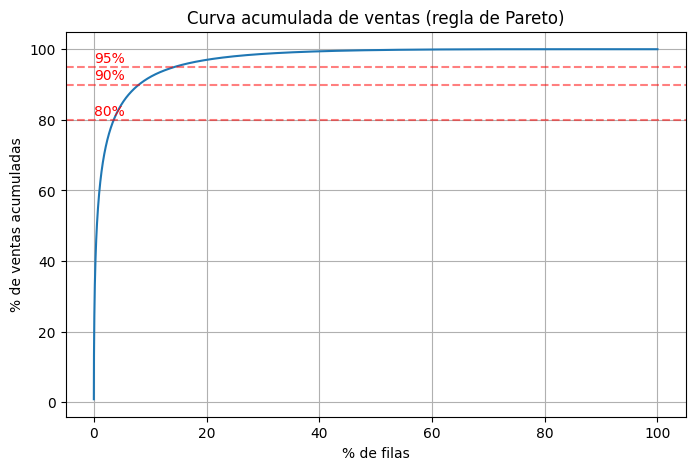

In [ ]:
# Vamos a ver ligeramente cómo se ordena entre cantidad de filas y % de ventas
# Calculamos el porcentaje de filas
df_ancho_prod_cliente_pred['pct_filas'] = np.array(range(1, len(df_ancho_prod_cliente_pred)+1)) / len(df_ancho_prod_cliente_pred)

# Graficamos
plt.figure(figsize=(8,5))
plt.plot(df_ancho_prod_cliente_pred['pct_filas']*100, df_ancho_prod_cliente_pred['Ventas_acumuladas']*100)
plt.xlabel('% de filas')
plt.ylabel('% de ventas acumuladas')
plt.title('Curva acumulada de ventas (regla de Pareto)')
plt.grid()

# Líneas de referencia para el 80, 90 y 95%
for y in [80, 90, 95]:
    plt.axhline(y, color='r', linestyle='--', alpha=0.5)
    plt.text(0, y+0.5, f'{y}%', color='r', va='bottom')

plt.show()

In [ ]:
# Esta es la matriz que quiero dividir en 4 clusters, 3 de DTW y basura.
# conservo la columna de total acumulado porque su suma me va a dar a entender
# cuánto se explica porqué cosa
df_ancho_prod_cliente_pred.reset_index(drop=True, inplace=True)
df_ancho_prod_cliente_pred.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,Filtro,Ventas_acumuladas,pct_filas
0,20002_10001,87.649,66.084,75.092,49.515,122.403,167.465,156.151,18.151,228.146,23.633,109.111,186.365,75.488,139.615,246.786,212.379,264.553,217.658,164.870,77.954,298.894,195.048,247.981,287.142,242.958,270.993,220.192,155.819,264.553,151.121,103.121,148.911,213.361,430.908,547.878,334.037,3083.853,0.009,3.805e-06
1,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219,2577.648,0.016,7.610e-06
2,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648,2043.935,0.021,1.142e-05
3,20001_10007,65.121,28.934,73.874,113.027,216.361,44.828,44.078,31.396,144.670,114.292,83.466,81.698,49.484,89.627,71.077,127.379,54.778,100.729,154.399,125.441,163.887,121.991,105.098,89.953,146.512,108.067,243.242,82.806,80.588,98.578,105.972,189.988,209.233,160.436,116.614,109.557,1651.593,0.026,1.522e-05
4,20002_10007,NaN,NaN,23.870,56.195,57.155,75.465,78.731,11.811,138.554,71.486,72.466,27.622,106.078,34.485,84.092,141.791,119.449,129.146,162.169,168.921,73.658,169.412,146.088,82.988,65.555,128.142,95.041,118.711,72.184,93.545,130.006,114.292,189.177,281.316,103.299,147.315,1538.584,0.030,1.903e-05


In [ ]:
df_ancho_prod_cliente_pred.to_csv(DATOS_DIR +'df_ancho_prod_cliente_pred_long.csv', index=False)

In [ ]:
suma=df_ancho_prod_cliente_pred['Filtro'].sum()
print(suma)

358659.45010000013


## comienzo a dividir el df por cluster1, 2, 3, sobras

##### traigo los clusters

In [ ]:
df_resultados_pc_fil_93 = pd.read_csv(DATOS_DIR +'df_ProdId_cluster_dtw_fil_93.csv')
df_resultados_pc_fil_93.head()

,cluster_id
0,1
1,2
2,2
3,3
4,1


In [ ]:
df_desvios_pc_fil3= pd.read_csv(DATOS_DIR +'desvios_df_pc_fil3_long93.csv')
df_desvios_pc_fil3.head()

,product_cust_id,std_ventas
0,20002_10001,110.699
1,20001_10001,106.033
2,20001_10004,114.273
3,20001_10007,51.573
4,20002_10007,54.293


In [ ]:
df_llave = pd.concat([df_resultados_pc_fil_93, df_desvios_pc_fil3], axis=1)
df_llave.head()

,cluster_id,product_cust_id,std_ventas
0,1,20002_10001,110.699
1,2,20001_10001,106.033
2,2,20001_10004,114.273
3,3,20001_10007,51.573
4,1,20002_10007,54.293


In [ ]:
df_llave.to_csv(DATOS_DIR +'df_llave_cluster_93.csv', index=False)

In [ ]:
#ahora quiero df_llave1 solamente con los valores de cluster_id =1
df_llave1 = df_llave[df_llave['cluster_id'] == 1]
df_llave1.head()

,cluster_id,product_cust_id,std_ventas
0,1,20002_10001,110.699
4,1,20002_10007,54.293
12,1,20009_10006,43.633
20,1,20002_10011,27.976
26,1,20001_10002,33.122


In [ ]:
#ahora quiero df_llave1 solamente con los valores de cluster_id =2
df_llave2 = df_llave[df_llave['cluster_id'] == 2]
df_llave2.head()

,cluster_id,product_cust_id,std_ventas
1,2,20001_10001,106.033
2,2,20001_10004,114.273
9,2,20005_10006,61.479
10,2,20003_10004,53.113
11,2,20001_10012,74.315


In [ ]:
#ahora quiero df_llave3 solamente con los valores de cluster_id =3.
df_llave3 = df_llave[df_llave['cluster_id'] == 3]
df_llave3.head()

,cluster_id,product_cust_id,std_ventas
3,3,20001_10007,51.573
5,3,20001_10003,69.411
6,3,20001_10013,47.716
7,3,20002_10004,76.865
8,3,20003_10001,65.379


#### Ahora selecciono de la matriz ancha por los archivos llave

###### cluster 1

In [ ]:
# 1. Filtrar los que coinciden
df_cluster_1 = df_ancho_prod_cliente_pred[df_ancho_prod_cliente_pred['cust_prod_id'].isin(df_llave1['product_cust_id'])]
suma1 = df_cluster_1['Filtro'].sum()
acum1=suma1/suma

# 2. Filtrar los que NO coinciden
df_restantes1 = df_ancho_prod_cliente_pred[~df_ancho_prod_cliente_pred['cust_prod_id'].isin(df_llave1['product_cust_id'])]

print("Filas en df_cluster_1:", len(df_cluster_1))
print("Ventas en cluster 1:", suma1)
print("Porcentaje de ventas en cluster 1:", acum1)
print("Filas en df_restantes1:", len(df_restantes1))
#

Filas en df_cluster_1: 6785
Ventas en cluster 1: 58711.65992
Porcentaje de ventas en cluster 1: 0.1636975127900024
Filas en df_restantes1: 256020


In [ ]:
# 1. Filtrar los que coinciden
df_cluster_2 = df_restantes1[df_restantes1['cust_prod_id'].isin(df_llave2['product_cust_id'])]
suma2 = df_cluster_2['Filtro'].sum()
acum2=suma2/suma

# 2. Filtrar los que NO coinciden
df_restantes2 = df_restantes1[~df_restantes1['cust_prod_id'].isin(df_llave2['product_cust_id'])]

print("Filas en df_cluster_1:", len(df_cluster_2))
print("Ventas en cluster 1:", suma2)
print("Porcentaje de ventas en cluster 1:", acum2)
print("Filas en df_restantes1:", len(df_restantes2))

Filas en df_cluster_1: 16101
Ventas en cluster 1: 197842.91063000003
Porcentaje de ventas en cluster 1: 0.5516177269965651
Filas en df_restantes1: 239919


In [ ]:
# 1. Filtrar los que coinciden
df_cluster_3 = df_restantes2[df_restantes2['cust_prod_id'].isin(df_llave3['product_cust_id'])]
suma3 = df_cluster_3['Filtro'].sum()
acum3=suma3/suma

# 2. Filtrar los que NO coinciden
df_restantes3 = df_restantes2[~df_restantes2['cust_prod_id'].isin(df_llave3['product_cust_id'])]

print("Filas en df_cluster_3:", len(df_cluster_3))
print("Ventas en cluster 3:", suma3)
print("Porcentaje de ventas en cluster 3:", acum3)
print("Filas en df_restantes3:", len(df_restantes3))

Filas en df_cluster_3: 5418
Ventas en cluster 3: 73002.25025000001
Porcentaje de ventas en cluster 3: 0.20354196781834633
Filas en df_restantes3: 234501


In [ ]:
suma_resto=df_restantes3['Filtro'].sum()
acum_resto=suma_resto/suma
print("Ventas en resto:", suma_resto)
print("Porcentaje de ventas en resto:", acum_resto)

Ventas en resto: 29102.6293
Porcentaje de ventas en resto: 0.08114279239508596


In [ ]:
df_ancho_prod_cliente_fil_93 = df_ancho_prod_cliente_fil2[df_ancho_prod_cliente_fil2['Ventas_acumuladas'] <= 0.93]
df_ancho_prod_cliente_fil_93.shape

(31941, 40)

In [ ]:
df_ancho_prod_cliente_fil_93.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,Filtro,Ventas_acumuladas,pct_filas
397,20002_10001,87.649,66.084,75.092,49.515,122.403,167.465,156.151,18.151,228.146,23.633,109.111,186.365,75.488,139.615,246.786,212.379,264.553,217.658,164.870,77.954,298.894,195.048,247.981,287.142,242.958,270.993,220.192,155.819,264.553,151.121,103.121,148.911,213.361,430.908,547.878,334.037,3083.853,0.008,3.724e-06
0,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219,2577.648,0.015,7.448e-06
3,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648,2043.935,0.020,1.117e-05
6,20001_10007,65.121,28.934,73.874,113.027,216.361,44.828,44.078,31.396,144.670,114.292,83.466,81.698,49.484,89.627,71.077,127.379,54.778,100.729,154.399,125.441,163.887,121.991,105.098,89.953,146.512,108.067,243.242,82.806,80.588,98.578,105.972,189.988,209.233,160.436,116.614,109.557,1651.593,0.025,1.490e-05
403,20002_10007,NaN,NaN,23.870,56.195,57.155,75.465,78.731,11.811,138.554,71.486,72.466,27.622,106.078,34.485,84.092,141.791,119.449,129.146,162.169,168.921,73.658,169.412,146.088,82.988,65.555,128.142,95.041,118.711,72.184,93.545,130.006,114.292,189.177,281.316,103.299,147.315,1538.584,0.029,1.862e-05


In [ ]:
# tengo que dropear las columnas Filtro y ventas_acumuladas y pct filas
df_ancho_prod_cliente_fil_93 = df_ancho_prod_cliente_fil_93.drop(columns=['Filtro', 'Ventas_acumuladas','pct_filas'])
df_ancho_prod_cliente_fil_93.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
397,20002_10001,87.649,66.084,75.092,49.515,122.403,167.465,156.151,18.151,228.146,23.633,109.111,186.365,75.488,139.615,246.786,212.379,264.553,217.658,164.870,77.954,298.894,195.048,247.981,287.142,242.958,270.993,220.192,155.819,264.553,151.121,103.121,148.911,213.361,430.908,547.878,334.037
0,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219
3,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648
6,20001_10007,65.121,28.934,73.874,113.027,216.361,44.828,44.078,31.396,144.670,114.292,83.466,81.698,49.484,89.627,71.077,127.379,54.778,100.729,154.399,125.441,163.887,121.991,105.098,89.953,146.512,108.067,243.242,82.806,80.588,98.578,105.972,189.988,209.233,160.436,116.614,109.557
403,20002_10007,NaN,NaN,23.870,56.195,57.155,75.465,78.731,11.811,138.554,71.486,72.466,27.622,106.078,34.485,84.092,141.791,119.449,129.146,162.169,168.921,73.658,169.412,146.088,82.988,65.555,128.142,95.041,118.711,72.184,93.545,130.006,114.292,189.177,281.316,103.299,147.315


In [ ]:
# tengo que resetear el índice de df
df_ancho_prod_cliente_fil_93 = df_ancho_prod_cliente_fil_93.reset_index(drop=True)
df_ancho_prod_cliente_fil_93.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,20002_10001,87.649,66.084,75.092,49.515,122.403,167.465,156.151,18.151,228.146,23.633,109.111,186.365,75.488,139.615,246.786,212.379,264.553,217.658,164.870,77.954,298.894,195.048,247.981,287.142,242.958,270.993,220.192,155.819,264.553,151.121,103.121,148.911,213.361,430.908,547.878,334.037
1,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219
2,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648
3,20001_10007,65.121,28.934,73.874,113.027,216.361,44.828,44.078,31.396,144.670,114.292,83.466,81.698,49.484,89.627,71.077,127.379,54.778,100.729,154.399,125.441,163.887,121.991,105.098,89.953,146.512,108.067,243.242,82.806,80.588,98.578,105.972,189.988,209.233,160.436,116.614,109.557
4,20002_10007,NaN,NaN,23.870,56.195,57.155,75.465,78.731,11.811,138.554,71.486,72.466,27.622,106.078,34.485,84.092,141.791,119.449,129.146,162.169,168.921,73.658,169.412,146.088,82.988,65.555,128.142,95.041,118.711,72.184,93.545,130.006,114.292,189.177,281.316,103.299,147.315


In [ ]:
# voy a guardar un csv con el df
df_ancho_prod_cliente_fil_93.to_csv(DATOS_DIR +'df_ancho_prod_cliente_fil_93_long.csv', index=False)

## ahora vamos a clusterizar por similitud

In [ ]:
total_filas = len(df_ancho_prod_cliente_fil_93)
sin_nan = (df_ancho_prod_cliente_fil_93.isna().sum(axis=1) == 0).sum()
con_nan = total_filas - sin_nan

print(f"Total filas: {total_filas}")
print(f"Filas sin NaN: {sin_nan}")
print(f"Filas con al menos un NaN: {con_nan}")

Total filas: 31941
Filas sin NaN: 1466
Filas con al menos un NaN: 30475


In [ ]:
# OJO esto quiere decir que tengo algunos NaN que en realidad son ceros
def nan_interno_a_cero(row):
    # The row is already a Series, select only numerical values
    x = row.values.copy()

    # Find the first non-NaN value (start of the series)
    # Check if there are any non-NaN values before proceeding
    if np.any(~np.isnan(x)):
        first_idx = np.argmax(~np.isnan(x))
        # Find the last non-zero and non-NaN value
        def is_real(v):
            return not np.isnan(v) and v != 0
        real_idxs = [i for i, v in enumerate(x) if is_real(v)]
        last_idx = max(real_idxs) if real_idxs else first_idx # Use first_idx if no real values found after it


        # Only process if there is a valid range
        if first_idx != -1 and last_idx != -1:
            for i in range(first_idx, last_idx + 1):
                if np.isnan(x[i]):
                    x[i] = 0 # replace internal NaN with zero

        return pd.Series(x, index=row.index) # Return a Series with the same index
    else:
        return row # return the original row if no numerical values or all are NaN


# Select only the numerical columns before applying the function
numerical_df = df_ancho_prod_cliente_fil_93.select_dtypes(include=np.number)

# Apply the function to the numerical columns
df_corr_cli_prod_numerical = numerical_df.apply(nan_interno_a_cero, axis=1)

# Combine the 'cust_prod_id' column with the processed numerical columns
df_corr_cli_prod_fil3 = pd.concat([df_ancho_prod_cliente_fil_93['cust_prod_id'], df_corr_cli_prod_numerical], axis=1)


total_filas = len(df_corr_cli_prod_fil3)
sin_nan = (df_corr_cli_prod_fil3.isna().sum(axis=1) == 0).sum()
con_nan = total_filas - sin_nan

print(f"Total filas: {total_filas}")
print(f"Filas sin NaN: {sin_nan}")
print(f"Filas con al menos un NaN: {con_nan}")

Total filas: 31941
Filas sin NaN: 9006
Filas con al menos un NaN: 22935


In [ ]:
df_corr_cli_prod_fil3.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,20002_10001,87.649,66.084,75.092,49.515,122.403,167.465,156.151,18.151,228.146,23.633,109.111,186.365,75.488,139.615,246.786,212.379,264.553,217.658,164.870,77.954,298.894,195.048,247.981,287.142,242.958,270.993,220.192,155.819,264.553,151.121,103.121,148.911,213.361,430.908,547.878,334.037
1,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219
2,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648
3,20001_10007,65.121,28.934,73.874,113.027,216.361,44.828,44.078,31.396,144.670,114.292,83.466,81.698,49.484,89.627,71.077,127.379,54.778,100.729,154.399,125.441,163.887,121.991,105.098,89.953,146.512,108.067,243.242,82.806,80.588,98.578,105.972,189.988,209.233,160.436,116.614,109.557
4,20002_10007,NaN,NaN,23.870,56.195,57.155,75.465,78.731,11.811,138.554,71.486,72.466,27.622,106.078,34.485,84.092,141.791,119.449,129.146,162.169,168.921,73.658,169.412,146.088,82.988,65.555,128.142,95.041,118.711,72.184,93.545,130.006,114.292,189.177,281.316,103.299,147.315


In [ ]:
# 1. Serie con los product_id (strings)
productos_cliente_fil3 = df_corr_cli_prod_fil3.iloc[:, 0]  # o df['product_id'] si sabes el nombre
# productos ahora es una Serie de los IDs de producto
productos_cliente_fil3.head()

,cust_prod_id
0,20002_10001
1,20001_10001
2,20001_10004
3,20001_10007
4,20002_10007


In [ ]:
# 2. Calcular el desvío estándar (std) por fila, solo sobre los datos de ventas
desvios_pc_fil3 = df_corr_cli_prod_fil3.iloc[:, 1:].std(axis=1)

# 3. Normalizar cada fila (ventas / std), sin modificar la columna de los IDs
ventas_normalizadas_fil3 = df_corr_cli_prod_fil3.iloc[:, 1:].div(desvios_pc_fil3, axis=0)
ventas_normalizadas_fil3.head()

,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,0.792,0.597,0.678,0.447,1.106,1.513,1.411,0.164,2.061,0.213,0.986,1.684,0.682,1.261,2.229,1.919,2.390,1.966,1.489,0.704,2.700,1.762,2.240,2.594,2.195,2.448,1.989,1.408,2.390,1.365,0.932,1.345,1.927,3.893,4.949,3.018
1,0.938,1.875,0.872,0.125,0.953,1.208,0.954,0.409,2.729,2.095,1.052,1.238,0.468,0.834,2.025,1.253,1.563,0.870,2.415,1.313,3.382,2.313,2.273,2.401,3.646,2.923,1.231,3.436,4.149,0.622,1.365,0.317,1.028,1.660,2.232,1.700
2,1.617,0.910,2.585,2.167,1.648,1.707,3.320,2.075,1.240,3.827,1.606,0.756,3.623,1.218,2.523,1.521,2.004,2.104,1.335,3.368,1.672,4.108,0.841,2.072,0.615,1.359,0.898,0.802,3.404,0.584,2.001,0.841,2.523,2.844,1.712,0.303
3,1.263,0.561,1.432,2.192,4.195,0.869,0.855,0.609,2.805,2.216,1.618,1.584,0.959,1.738,1.378,2.470,1.062,1.953,2.994,2.432,3.178,2.365,2.038,1.744,2.841,2.095,4.716,1.606,1.563,1.911,2.055,3.684,4.057,3.111,2.261,2.124
4,NaN,NaN,0.440,1.035,1.053,1.390,1.450,0.218,2.552,1.317,1.335,0.509,1.954,0.635,1.549,2.612,2.200,2.379,2.987,3.111,1.357,3.120,2.691,1.529,1.207,2.360,1.751,2.187,1.330,1.723,2.395,2.105,3.484,5.181,1.903,2.713


In [ ]:
# 4. Guardar un DataFrame con los product_id y los desvíos usados
df_desvios_pc_fil3 = pd.DataFrame({
    'product_cust_id': productos_cliente_fil3,
    'std_ventas': desvios_pc_fil3
})
df_desvios_pc_fil3.head()

,product_cust_id,std_ventas
0,20002_10001,110.699
1,20001_10001,106.033
2,20001_10004,114.273
3,20001_10007,51.573
4,20002_10007,54.293


In [ ]:
#normailizo y guardo

ventas_normalizadas_fil3.to_parquet(DATOS_DIR +'df_norm_pc_fil3_long93.parquet', index=False)
df_desvios_pc_fil3.to_csv(DATOS_DIR +'desvios_df_pc_fil3_long93.csv', index=False)



In [ ]:
# genero cluster jerárquicos
# OJO voy a meter 0 en los NaN esto es algo a revisar luego
df_dtw_dist_pc = ventas_normalizadas_fil3
#df_dtw_dist = df_dtw_dist.fillna(0)
df_dtw_dist_pc.head()

,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,0.792,0.597,0.678,0.447,1.106,1.513,1.411,0.164,2.061,0.213,0.986,1.684,0.682,1.261,2.229,1.919,2.390,1.966,1.489,0.704,2.700,1.762,2.240,2.594,2.195,2.448,1.989,1.408,2.390,1.365,0.932,1.345,1.927,3.893,4.949,3.018
1,0.938,1.875,0.872,0.125,0.953,1.208,0.954,0.409,2.729,2.095,1.052,1.238,0.468,0.834,2.025,1.253,1.563,0.870,2.415,1.313,3.382,2.313,2.273,2.401,3.646,2.923,1.231,3.436,4.149,0.622,1.365,0.317,1.028,1.660,2.232,1.700
2,1.617,0.910,2.585,2.167,1.648,1.707,3.320,2.075,1.240,3.827,1.606,0.756,3.623,1.218,2.523,1.521,2.004,2.104,1.335,3.368,1.672,4.108,0.841,2.072,0.615,1.359,0.898,0.802,3.404,0.584,2.001,0.841,2.523,2.844,1.712,0.303
3,1.263,0.561,1.432,2.192,4.195,0.869,0.855,0.609,2.805,2.216,1.618,1.584,0.959,1.738,1.378,2.470,1.062,1.953,2.994,2.432,3.178,2.365,2.038,1.744,2.841,2.095,4.716,1.606,1.563,1.911,2.055,3.684,4.057,3.111,2.261,2.124
4,NaN,NaN,0.440,1.035,1.053,1.390,1.450,0.218,2.552,1.317,1.335,0.509,1.954,0.635,1.549,2.612,2.200,2.379,2.987,3.111,1.357,3.120,2.691,1.529,1.207,2.360,1.751,2.187,1.330,1.723,2.395,2.105,3.484,5.181,1.903,2.713


In [ ]:
df_dtw_dist_pc.shape

(31941, 36)

In [ ]:
## vamos a ver now dice que puede tomar series cortas, veremos
print("\nCreando la lista de series con su longitud real...")
# Changed dtype to np.double to match expected 'seq_t' type in dtaidistance C code
# Filter out empty series before creating the list
# series_list_pc_fil2 = [row.dropna().to_numpy(dtype=np.double) for index, row in df_dtw_dist_pc.iterrows() if not row.dropna().empty]
series_list_pc_fil3 = [
    np.array([v for v in row[1:] if not np.isnan(v)], dtype=np.double)
    for row in df_dtw_dist_pc.itertuples(index=False)
    if not np.all(np.isnan(row[1:]))
]


Creando la lista de series con su longitud real...


In [ ]:
# Indices de series que todavía contienen al menos un NaN:
series_with_nan = [i for i, serie in enumerate(series_list_pc_fil3) if np.isnan(serie).any()]

print(f"Cantidad de series con NaN internos: {len(series_with_nan)}")
if series_with_nan:
    print("Ejemplo de índice(s) con problemas:", series_with_nan[:5])
    # Puedes mirar la serie así:
    # print(series_list_pc_fil2[series_with_nan[0]])

Cantidad de series con NaN internos: 0


In [ ]:



# Verificamos que se haya creado correctamente
print(f"Tipo de dato creado: {type(series_list_pc_fil3)}")
print(f"Número de series en la lista: {len(series_list_pc_fil3)}")
print(f"Tipo de dato del primer elemento de la lista: {type(series_list_pc_fil3[0])}")
print(f"Longitud de la primera serie: {len(series_list_pc_fil3[0])}")
if len(series_list_pc_fil3) > 0:
    print(f"Longitud de la última serie (la corta): {len(series_list_pc_fil3[-1])}")
else:
    print("No series were created (all were empty).")

Tipo de dato creado: <class 'list'>
Número de series en la lista: 31941
Tipo de dato del primer elemento de la lista: <class 'numpy.ndarray'>
Longitud de la primera serie: 35
Longitud de la última serie (la corta): 27


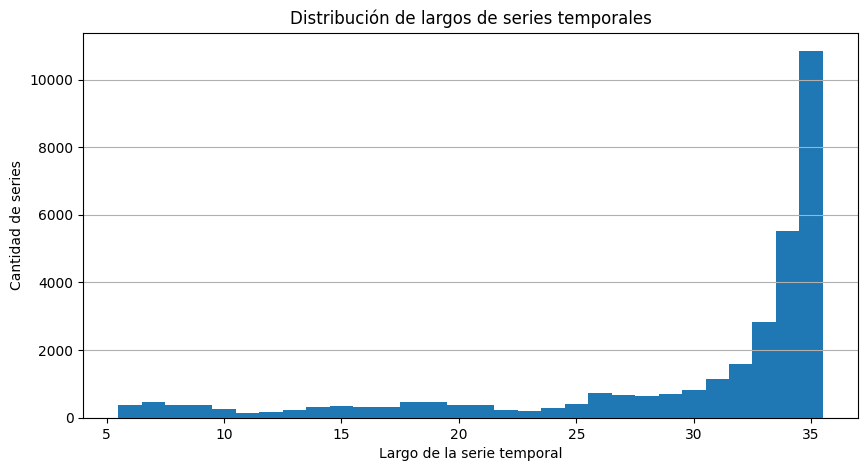

In [ ]:
# Conteo de largos
lengths = [len(s) for s in series_list_pc_fil3]
length_counts = pd.Series(lengths).value_counts().sort_index()

# Grafico de barras
plt.figure(figsize=(10,5))
plt.bar(length_counts.index, length_counts.values, width=1.0)
plt.xlabel('Largo de la serie temporal')
plt.ylabel('Cantidad de series')
plt.title('Distribución de largos de series temporales')
plt.grid(axis='y')
plt.show()

In [ ]:
# Esta es la parte computacionalmente más intensiva.
# dtaidistance usará todos los cores de CPU disponibles.
print("\nPaso 3: Calculando la matriz de distancias DTW...")
start_time = time.time()

# La función dtw.distance_matrix_fast es la clave.
# Utiliza una implementación en C con paralelización (OpenMP).
# `use_mp=True` activa el uso de múltiples procesadores.
ds_fil3 = dtw.distance_matrix_fast(series_list_pc_fil3, use_mp=True)

end_time = time.time()
print(f"Cálculo de la matriz de distancias finalizado en {end_time - start_time:.2f} segundos.")
print(f"Dimensiones de la matriz de distancias: {ds_fil3.shape}")


Paso 3: Calculando la matriz de distancias DTW...
Cálculo de la matriz de distancias finalizado en 988.34 segundos.
Dimensiones de la matriz de distancias: (31941, 31941)


In [ ]:
print(f"Cálculo de la matriz de distancias finalizado en {end_time - start_time:.2f} segundos.")
print(f"Dimensiones de la matriz de distancias: {ds_fil3.shape}")

Cálculo de la matriz de distancias finalizado en 988.34 segundos.
Dimensiones de la matriz de distancias: (31941, 31941)


In [ ]:
# ==============================================================================
# 4.5. ¡NUEVO! GUARDAR LA MATRIZ DE DISTANCIAS
# ==============================================================================
print("\nPaso 4.5: Guardando la matriz de distancias en un archivo...")

# Definimos el nombre del archivo
file_path = DATOS_DIR +'dtw_distance_matrix_pc_fil3_93.npy'

# Usamos np.save para guardar el array en formato binario de NumPy
np.save(file_path, ds_fil3)

print(f"Matriz guardada exitosamente en '{file_path}'.")
# Comprobamos el tamaño del archivo
#file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
#print(f"Tamaño del archivo: {file_size_mb:.2f} MB")


Paso 4.5: Guardando la matriz de distancias en un archivo...
Matriz guardada exitosamente en '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/dtw_distance_matrix_pc_fil3_93.npy'.


In [ ]:
ds_fil3.shape

(31941, 31941)

In [ ]:
es_simetrica = np.allclose(ds_fil3, ds_fil3.T)

print("¿Es simétrica?", es_simetrica)

¿Es simétrica? True


In [ ]:
asymmetry = np.abs(ds_fil3 - ds_fil3.T)
print("Máximo error de simetría:", asymmetry.max())
print("Promedio de error de simetría:", asymmetry.mean())

/tmp/ipython-input-49-3386619761.py:1: RuntimeWarning: invalid value encountered in subtract
  asymmetry = np.abs(ds_fil3 - ds_fil3.T)


Máximo error de simetría: nan
Promedio de error de simetría: nan


In [ ]:
# Obtener las posiciones donde hay NaN en ds_fil3
nan_rows, nan_cols = np.where(np.isnan(ds_fil3))
problematic_pairs = list(zip(nan_rows, nan_cols))
print(f'Cantidad de pares problemáticos: {len(problematic_pairs)}')
print("Ejemplo de pares (primeros 5):", problematic_pairs[:5])

Cantidad de pares problemáticos: 1190
Ejemplo de pares (primeros 5): [(np.int64(7803), np.int64(11745)), (np.int64(7803), np.int64(14765)), (np.int64(7803), np.int64(15366)), (np.int64(7803), np.int64(16050)), (np.int64(7803), np.int64(19701))]


In [ ]:
idx_1, idx_2 = problematic_pairs[0]
largo_1 = len(series_list_pc_fil3[idx_1])
largo_2 = len(series_list_pc_fil3[idx_2])
print(f'Par problemático: {idx_1} (largo {largo_1}) vs {idx_2} (largo {largo_2})')

Par problemático: 7803 (largo 2) vs 11745 (largo 2)


In [ ]:
# Encuentra para cada par problemático, los largos de las series
for (i, j) in problematic_pairs[:100]: # muestra los primeros 10
    print(f"Par {i}-{j}: largo1={len(series_list_pc_fil3[i])}, largo2={len(series_list_pc_fil3[j])}")

Par 7803-11745: largo1=2, largo2=2
Par 7803-14765: largo1=2, largo2=2
Par 7803-15366: largo1=2, largo2=2
Par 7803-16050: largo1=2, largo2=2
Par 7803-19701: largo1=2, largo2=3
Par 7803-23334: largo1=2, largo2=2
Par 7803-23335: largo1=2, largo2=2
Par 7803-23613: largo1=2, largo2=2
Par 7803-23614: largo1=2, largo2=2
Par 7803-23694: largo1=2, largo2=2
Par 7803-24132: largo1=2, largo2=2
Par 7803-24133: largo1=2, largo2=2
Par 7803-25296: largo1=2, largo2=2
Par 7803-25404: largo1=2, largo2=2
Par 7803-25417: largo1=2, largo2=2
Par 7803-25965: largo1=2, largo2=2
Par 7803-25966: largo1=2, largo2=2
Par 7803-25970: largo1=2, largo2=2
Par 7803-26448: largo1=2, largo2=2
Par 7803-28525: largo1=2, largo2=2
Par 7803-29080: largo1=2, largo2=2
Par 7803-29866: largo1=2, largo2=2
Par 7803-31464: largo1=2, largo2=2
Par 7803-36005: largo1=2, largo2=2
Par 7803-37081: largo1=2, largo2=4
Par 7803-37377: largo1=2, largo2=2
Par 7803-40484: largo1=2, largo2=2
Par 7803-42289: largo1=2, largo2=2
Par 7803-42753: larg

In [ ]:
# La función `linkage` de Scipy no trabaja con la matriz cuadrada completa,
# sino con una forma "condensada" (un vector con las distancias del triángulo superior).
# `squareform` hace esta conversión por nosotros. Es un paso obligatorio.
condensed_ds_fil3 = squareform(ds_fil3)

print(f"Dimensiones de la matriz de distancias original: {ds_fil3.shape}")
print(f"Dimensiones de la matriz de distancias condensada: {condensed_ds_fil3.shape}")

Dimensiones de la matriz de distancias original: (31941, 31941)
Dimensiones de la matriz de distancias condensada: (510097770,)


In [ ]:
# `linkage` es la función que realiza el clustering.
# Parámetros clave:
#   - condensed_ds: Tu matriz de distancias ya preparada.
#   - method='ward': El método de enlace. 'ward' es una excelente opción por defecto.
#     Busca minimizar la varianza dentro de cada cluster. Otras opciones comunes
#     son 'average', 'complete', 'single'.
model_fil = linkage(condensed_ds_fil3, method='ward')

print("\nModelo de clustering jerárquico creado.")


Modelo de clustering jerárquico creado.


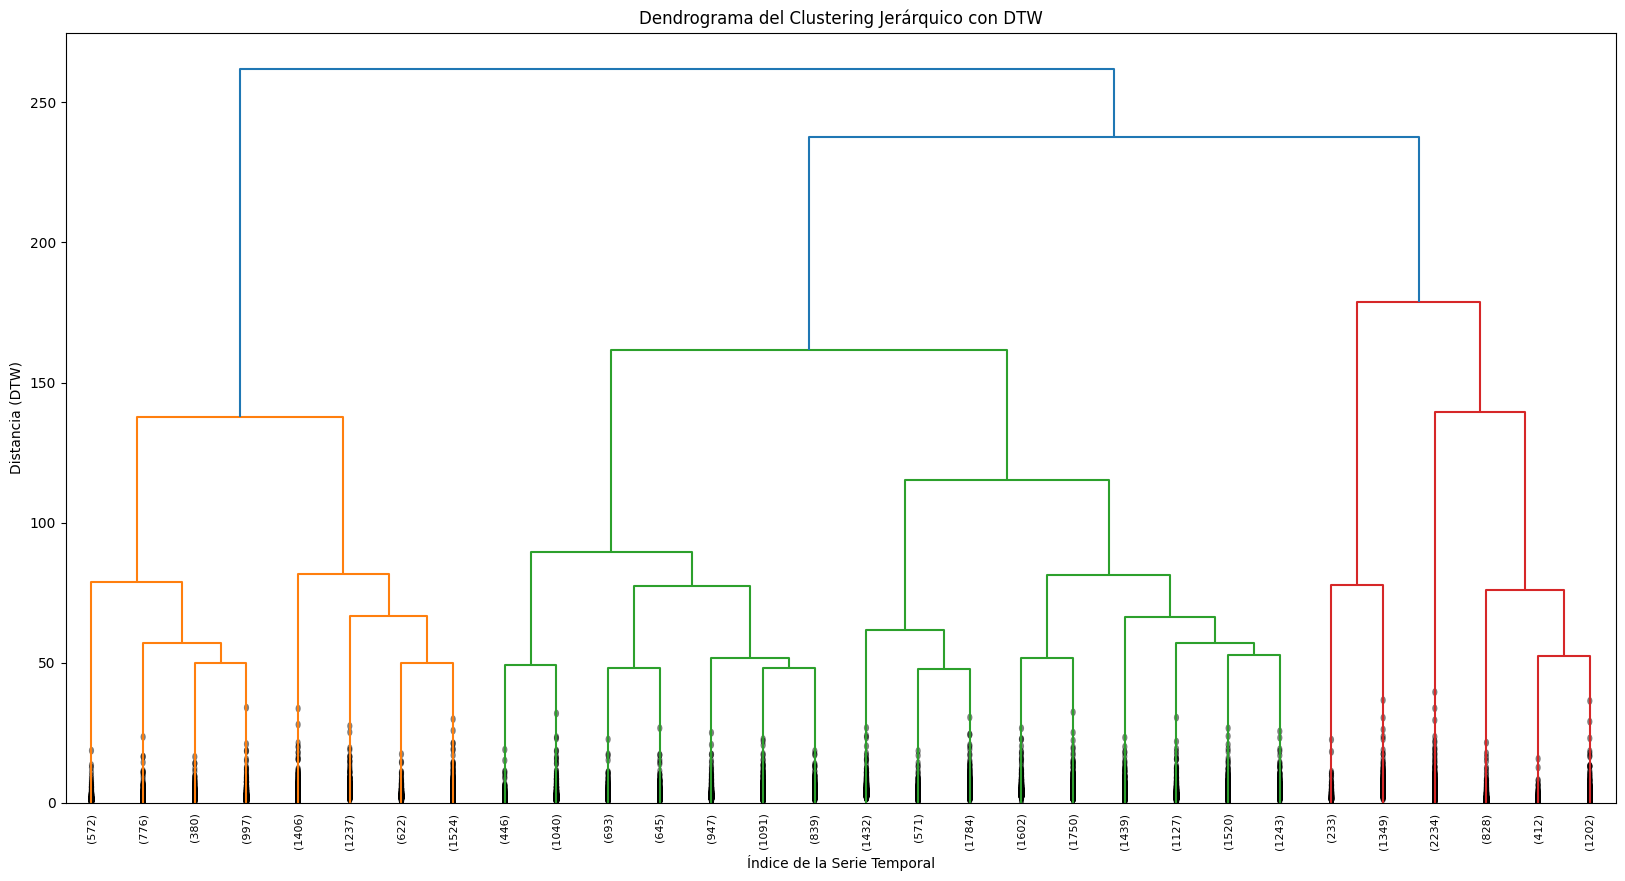

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Dendrograma del Clustering Jerárquico con DTW')
plt.xlabel('Índice de la Serie Temporal')
plt.ylabel('Distancia (DTW)')

# `dendrogram` dibuja el árbol.
# Para datasets grandes (como el tuyo de 1250 series), es imposible etiquetar todo.
# `truncate_mode='lastp'` y `p=30` son tus mejores amigos aquí:
# Muestran los últimos 30 clusters fusionados, que es la parte más importante.
dendrogram(
    model_fil,
    truncate_mode='lastp',  # Muestra solo los últimos 'p' clusters fusionados
    p=30,                   # El número de clusters finales a mostrar
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,   # Para representar el tamaño de los clusters no mostrados
)
plt.show()

In [ ]:
# ==============================================================================
# 4. EXTRAER LOS CLUSTERS
# ==============================================================================


# Una vez que has visto el dendrograma, puedes "cortarlo" a una altura
# determinada o especificar el número de clusters que quieres.

# Opción A: Especificar el número de clusters (la más común)
# Mirando el dendrograma, decides que quieres, por ejemplo, 5 clusters.
num_clusters = 3
clusters = fcluster(model_fil, t=num_clusters, criterion='maxclust')

# Opción B: Cortar por distancia (útil si tienes una idea de la escala de distancia)
# max_distancia = 20  # Por ejemplo, todos los clusters por debajo de esta distancia se fusionan
# clusters = fcluster(model, t=max_distancia, criterion='distance')

print(f"\nAsignación de clusters para las primeras 20 series (para {num_clusters} clusters):")
# `clusters` es un array donde el valor en la posición `i` es el ID del cluster
# al que pertenece la serie `i`.
for i in range(20):
    print(f"Serie {i} -> Cluster {clusters[i]}")


Asignación de clusters para las primeras 20 series (para 3 clusters):
Serie 0 -> Cluster 1
Serie 1 -> Cluster 2
Serie 2 -> Cluster 2
Serie 3 -> Cluster 3
Serie 4 -> Cluster 1
Serie 5 -> Cluster 3
Serie 6 -> Cluster 3
Serie 7 -> Cluster 3
Serie 8 -> Cluster 3
Serie 9 -> Cluster 2
Serie 10 -> Cluster 2
Serie 11 -> Cluster 2
Serie 12 -> Cluster 1
Serie 13 -> Cluster 2
Serie 14 -> Cluster 2
Serie 15 -> Cluster 3
Serie 16 -> Cluster 2
Serie 17 -> Cluster 2
Serie 18 -> Cluster 2
Serie 19 -> Cluster 2


In [ ]:
# Ahora puedes, por ejemplo, añadir esta información a un DataFrame para análisis posterior

df_resultados_pc_fil = pd.DataFrame({
    'product_cus_id': productos_cliente_fil3,
    'cluster_id': clusters
})

In [ ]:

# Opcional: Establecer 'product_id' como el índice del nuevo DataFrame
df_resultados_pc_fil.set_index('product_cus_id', inplace=True)


print("\nDataFrame de Resultados (product_id -> cluster_id):")
print(df_resultados_pc_fil.head())

# Puedes verificar la distribución de productos por cluster
print("\nConteo de productos por cluster:")
print(df_resultados_pc_fil['cluster_id'].value_counts())


DataFrame de Resultados (product_id -> cluster_id):
                cluster_id
product_cus_id            
20002_10001              1
20001_10001              2
20001_10004              2
20001_10007              3
20002_10007              1

Conteo de productos por cluster:
cluster_id
2    18169
1     7514
3     6258
Name: count, dtype: int64


In [ ]:
# 3lijo y guardo clusters por producto
df_resultados_pc_fil.to_csv(DATOS_DIR +'df_ProdId_cluster_dtw_fil_93.csv', index=False)